# 1. Import and Install Dependencies

## 1.1 Install Dependencies

In [ ]:
!pip install tensorflow-io==0.31.0 tensorflow==2.11

## 1.2 Load Dependencies

In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf 
import tensorflow_io as tfio

# 2. Build Data Loading Function

## 2.1 Define Paths to Files

In [2]:
CAPUCHIN_FILE = os.path.join('dataset', 'positive', 'dice-01 Comp 1.wav')
NOT_CAPUCHIN_FILE = os.path.join('dataset', 'negative', 'place Comp 1.wav')

## 2.2 Build Dataloading Function

In [3]:
def load_wav_16k_mono(filename):
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    # Decode wav (tensors by channels) 
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    # Removes trailing axis
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Goes from 44100Hz to 16000hz - amplitude of the audio signal
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

## 2.3 Plot Wave

In [4]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)

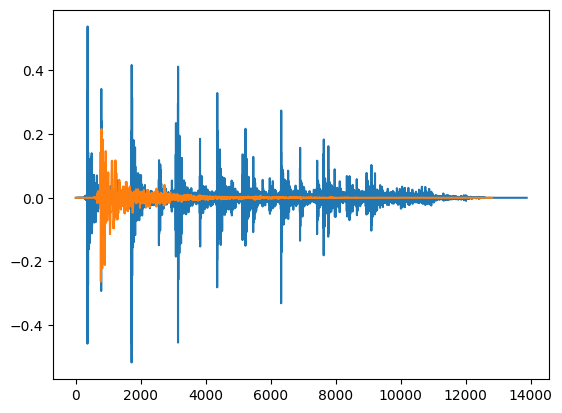

In [5]:
plt.plot(wave)
plt.plot(nwave)
plt.show()

# 3. Create Tensorflow Dataset

## 3.1 Define Paths to Positive and Negative Data

In [6]:
POS = os.path.join('dataset', 'positive')
NEG = os.path.join('dataset', 'negative')

## 3.2 Create Tensorflow Datasets

In [7]:
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')

## 3.3 Add labels and Combine Positive and Negative Samples

In [8]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))
data = positives.concatenate(negatives)

In [9]:
tf.ones(len(pos))

<tf.Tensor: shape=(19,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1.], dtype=float32)>

In [10]:
data.shuffle(10000).as_numpy_iterator().next()

(b'dataset\\negative\\bell Comp 7.wav', 0.0)

# 4. Determine Average Length of a Capuchin Call

## 4.1 Calculate Wave Cycle Length

In [11]:
lengths = []
for file in os.listdir(os.path.join('dataset', 'positive')):
    tensor_wave = load_wav_16k_mono(os.path.join('dataset', 'positive', file))
    lengths.append(len(tensor_wave))

## 4.2 Calculate Mean, Min and Max

In [12]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=18631>

In [13]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=13882>

In [14]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=23493>

# 5. Build Preprocessing Function to Convert to Spectrogram

## 5.1 Build Preprocessing Function

In [15]:
def preprocess(file_path, label): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:13000]
    zero_padding = tf.zeros([13000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=500, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

## 5.2 Test Out the Function and Viz the Spectrogram

In [16]:
filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()

In [17]:
spectrogram, label = preprocess(filepath, label)

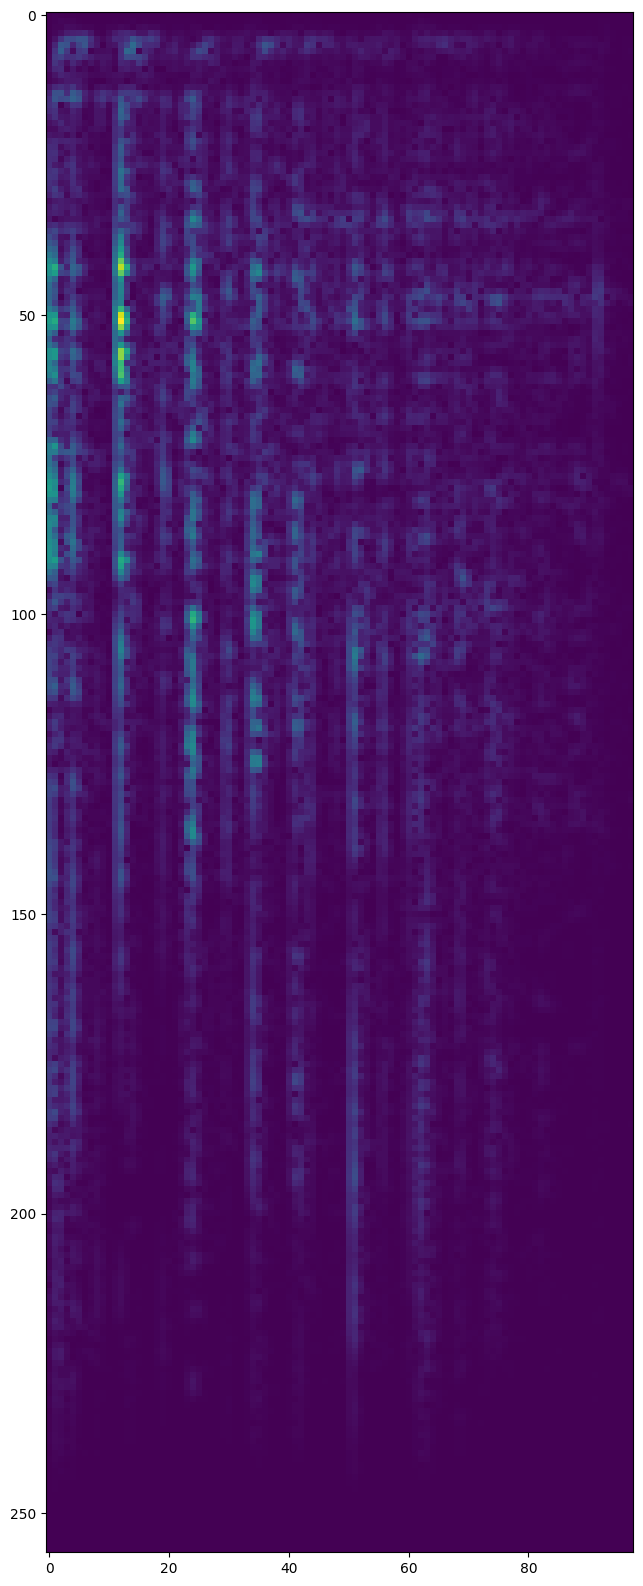

In [18]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# 6. Create Training and Testing Partitions

## 6.1 Create a Tensorflow Data Pipeline

In [19]:
data = data.map(preprocess)
data = data.cache()
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


## 6.2 Split into Training and Testing Partitions

In [20]:
train = data.take(4)
test = data.skip(4).take(2)

In [ ]:
len(data)*0.7

## 6.3 Test One Batch

In [21]:
samples, labels = train.as_numpy_iterator().next()

In [22]:
samples.shape

(16, 98, 257, 1)

# 7. Build Deep Learning Model

## 7.1 Load Tensorflow Dependencies

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

## 7.2 Build Sequential Model, Compile and View Summary

In [24]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(98, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [25]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 255, 16)       160       
                                                                 
 conv2d_1 (Conv2D)           (None, 94, 253, 16)       2320      
                                                                 
 flatten (Flatten)           (None, 380512)            0         
                                                                 
 dense (Dense)               (None, 128)               48705664  
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 48,708,273
Trainable params: 48,708,273
Non-trainable params: 0
_________________________________________________________________


## 7.3 Fit Model, View Loss and KPI Plots

In [57]:
hist = model.fit(train, epochs=4, validation_data=test)

Epoch 1/4
4/4 [==============================] - 1s 354ms/step - loss: 1.3461e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.9018e-22 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/4
4/4 [==============================] - 1s 351ms/step - loss: 1.2220e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 8.4117e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/4
4/4 [==============================] - 1s 368ms/step - loss: 1.1046e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 3.6395e-26 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 4/4
4/4 [==============================] - 1s 351ms/step - loss: 1.0550e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.3578e-07 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00


In [28]:
hist = model.fit(train, epochs=8, validation_data=test)

Epoch 1/8
4/4 [==============================] - 1s 331ms/step - loss: 4.3332e-05 - recall: 1.0000 - precision: 1.0000 - val_loss: 2.0906e-37 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 2/8
4/4 [==============================] - 1s 360ms/step - loss: 6.8869e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.2696e-05 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 3/8
4/4 [==============================] - 1s 363ms/step - loss: 2.2168e-06 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0000e+00 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/8
4/4 [==============================] - 1s 358ms/step - loss: 9.0051e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 1.6615e-06 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 5/8
4/4 [==============================] - 1s 360ms/step - loss: 4.5080e-07 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0000e+00 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 6/8
4/4 [==========================

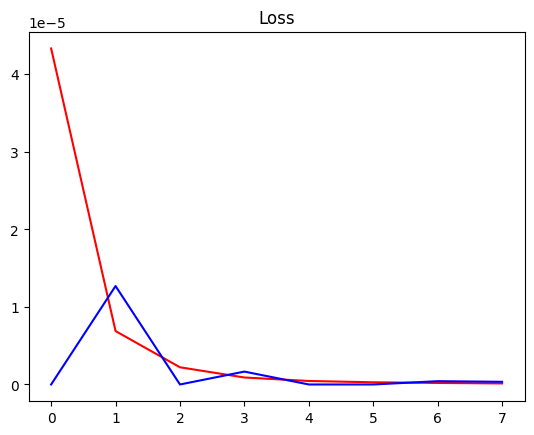

In [29]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

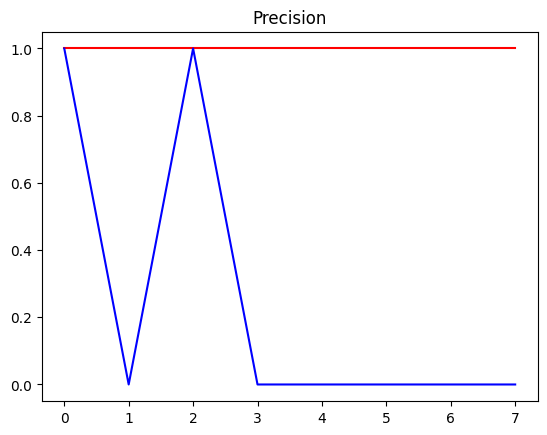

In [30]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

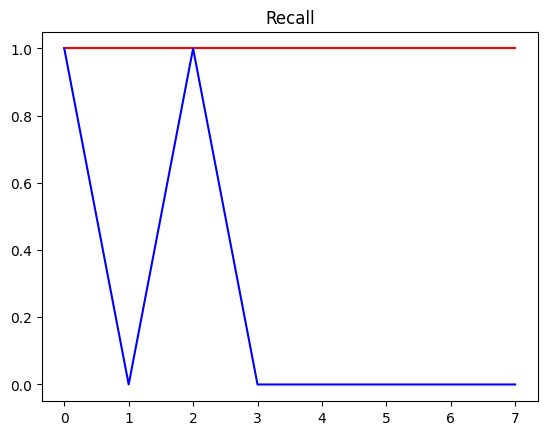

In [31]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

# 8. Make a Prediction on a Single Clip

## 8.1 Get One Batch and Make a Prediction

In [58]:
X_test, y_test = test.as_numpy_iterator().next()

In [59]:
yhat = model.predict(X_test)

1/1 [==============================] - 0s 33ms/step


## 8.2 Convert Logits to Classes 

In [77]:
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

# 9. Build Forest Parsing Functions

## 9.1 Load up MP3s

In [78]:
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [79]:
mp3 = os.path.join('dataset', 'test', '01-11 Rolls.wav')

In [80]:
wav = load_mp3_16k_mono(mp3)

In [81]:
wav

<tf.Tensor: shape=(960021,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [82]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=13000, sequence_stride=13000, batch_size=1)

In [83]:
samples, index = audio_slices.as_numpy_iterator().next()

In [84]:
samples.shape

(1, 13000)

In [85]:
len(audio_slices)

73

## 9.2 Build Function to Convert Clips into Windowed Spectrograms

In [86]:
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([13000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=500, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

## 9.3 Convert Longer Clips into Windows and Make Predictions

In [87]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=13000, sequence_stride=13000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [88]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

2/2 [==============================] - 0s 20ms/step


In [89]:
len(yhat)

73

In [90]:
yhat

[1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

## 9.4 Group Consecutive Detections

In [91]:
from itertools import groupby

In [92]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [93]:
calls

8

# 9.9 Save Model

In [94]:
# Assuming 'model' is your trained model
model.save('tf.io3-first-try3.h5')